In [1]:
import h5py
import math
import os
import re
import sys
from collections import defaultdict
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from tqdm.notebook import tqdm

from genomic_utils.variant import Variant

sys.path += ["../", "../../vcf_utils"]
import evaluation_utils
import utils

In [6]:
TRAIN_H5_PATH = "../../finetuning/data/h5_bins_384_chrom_split/train.h5"
TEST_H5_PATH = "../../finetuning/data/h5_bins_384_chrom_split/test.h5"

GEUVADIS_COUNTS_PATH = (
    "../../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
)
CONTEXT_SIZE = 128 * 384

FIGURES_DIR = "../figures"

# Helper functions

In [9]:
def get_training_genes():
    gene_to_class_map = evaluation_utils.get_gene_to_class_map()
    train_genes = {g for g, c in gene_to_class_map.items() if c != "unseen"}
    assert len(train_genes) == 400
    return train_genes

In [10]:
def get_samples_per_gene(h5_path: str) -> dict[str, set]:
    samples_per_gene = defaultdict(set)
    with h5py.File(h5_path, "r") as f:
        genes = f["genes"][:].astype(str)
        samples = f["samples"][:].astype(str)
        for (gene, sample) in zip(genes, samples):
            samples_per_gene[gene].add(sample)
    return samples_per_gene

In [11]:
def compute_alternate_allele_frequency(geno_mtx: pd.DataFrame) -> pd.Series:
    ac = geno_mtx.applymap(utils.convert_to_dosage).sum(axis=1)
    an = geno_mtx.applymap(utils.count_total_alleles).sum(axis=1)
    aaf = ac / an
    return aaf

# Find alleles unobserved during training

In [12]:
counts_df = pd.read_csv(GEUVADIS_COUNTS_PATH, index_col="our_gene_name")
training_genes = get_training_genes()
train_samples_per_gene = get_samples_per_gene(TRAIN_H5_PATH)
test_samples_per_gene = get_samples_per_gene(TEST_H5_PATH)

In [11]:
unseen_alleles = defaultdict(list)
n_test_alleles_per_gene = defaultdict(int)
n_total_alleles_per_gene = defaultdict(int)

for gene in tqdm(training_genes):
    geno_mtx = utils.get_genotype_matrix(
        counts_df.loc[gene, "Chr"],
        counts_df.loc[gene, "Coord"],
        CONTEXT_SIZE,
        remove_ac0=True,
        remove_ac1=True
    )
    train_samples = sorted(train_samples_per_gene[gene])
    test_samples = sorted(test_samples_per_gene[gene])

    train_aaf = compute_alternate_allele_frequency(geno_mtx[train_samples])
    test_aaf = compute_alternate_allele_frequency(geno_mtx[test_samples])
    comb_aaf = compute_alternate_allele_frequency(
        geno_mtx[train_samples + test_samples]
    )

    # Find alt alleles present in test, but not in train
    seen_train_alt = set(train_aaf[train_aaf > 0].index)
    seen_test_alt = set(test_aaf[test_aaf > 0].index)
    unseen_test_alt = seen_test_alt - seen_train_alt
    for v in unseen_test_alt:
        unseen_alleles["gene"].append(gene)
        unseen_alleles["variant"].append(v)
        unseen_alleles["pos"].append(v.pos)
        unseen_alleles["allele"].append(v.alt)
        unseen_alleles["test_af"].append(test_aaf[v])

    # Find ref alleles present in test, but not in train
    seen_train_ref = set(train_aaf[train_aaf < 1.0].index)
    seen_test_ref = set(test_aaf[test_aaf < 1.0].index)
    unseen_test_ref = seen_test_ref - seen_train_ref
    for v in unseen_test_ref:
        unseen_alleles["gene"].append(gene)
        unseen_alleles["variant"].append(v)
        unseen_alleles["pos"].append(v.pos)
        unseen_alleles["allele"].append(v.ref)
        unseen_alleles["test_af"].append(1 - test_aaf[v])

    # Find the total number of alleles that are contained in this gene
    n_test_alleles_per_gene[gene] += (test_aaf > 0).sum()  # alt
    n_test_alleles_per_gene[gene] += (test_aaf < 1).sum()  # ref

    n_total_alleles_per_gene[gene] += (comb_aaf > 0).sum()  # alt
    n_total_alleles_per_gene[gene] += (comb_aaf < 1).sum()  # ref

  0%|          | 0/400 [00:00<?, ?it/s]

In [12]:
unseen_alleles_df = pd.DataFrame(unseen_alleles)
unseen_alleles_df.head()

,gene,variant,pos,allele,test_af
0,cdc34,chr19:536782 C/T,536782,T,0.006494
1,cdc34,chr19:536335 C/T,536335,T,0.006494
2,cdc34,chr19:548244 G/A,548244,A,0.006494
3,cdc34,chr19:534234 C/T,534234,T,0.006494
4,cdc34,chr19:542867 T/G,542867,G,0.006494


In [13]:
# Ensure test allele frequencies are at least 1 / (2 * n_test_samples)
min_possible_test_af = 1 / (2 * len(test_samples))
eps = np.finfo(float).eps
assert unseen_alleles_df["test_af"].min() + eps >= min_possible_test_af

In [21]:
unseen_alleles_df.to_csv("unseen_alleles.csv", index=False)

# Plot statistics about unseen alleles

In [7]:
unseen_alleles_df = pd.read_csv("unseen_alleles.csv")
unseen_alleles_df.head()

,gene,variant,pos,allele,test_af
0,kalrn,chr3:123795903 C/T,123795903,T,0.006494
1,kalrn,chr3:123812461 A/G,123812461,G,0.019481
2,kalrn,chr3:123783753 A/G,123783753,G,0.045455
3,kalrn,chr3:123795380 G/A,123795380,A,0.025974
4,kalrn,chr3:123801810 C/T,123801810,T,0.006494


In [25]:
def plot_results(
    unseen_alleles_df: pd.DataFrame,
    n_test_alleles_per_gene: dict[str, int],
    gene_to_class_map: dict[str, str],
    savepath: Optional[str] = None,
):
    fig, axs = plt.subplots(ncols=2, figsize=(14, 5))

    # (A) Plot the KDE of the fraction of unseen variants, stratified by gene class
    unseen_counts = unseen_alleles_df.groupby("gene")["variant"].count()
    unseen_counts_df = pd.DataFrame(unseen_counts).rename(
        columns={"variant": "n_unseen"}
    )
    unseen_counts_df["n_test"] = unseen_counts_df.index.map(n_test_alleles_per_gene)
    unseen_counts_df["fraction"] = (
        unseen_counts_df["n_unseen"] / unseen_counts_df["n_test"]
    )
    unseen_counts_df["gene_class"] = unseen_counts_df.index.map(gene_to_class_map)
    unseen_counts_df["gene_class"] = unseen_counts_df["gene_class"].map(
        {"random_split": "Random-split genes", "yri_split": "Population-split genes"}
    )

    sns.histplot(
        data=unseen_counts_df,
        x="fraction",
        hue="gene_class",
        hue_order=["Random-split genes", "Population-split genes"],
        stat="probability",
        common_norm=False,
        bins=20,
        ax=axs[0],
    )
    axs[0].set_ylabel("Probability", fontsize=12)
    axs[0].set_xlabel("Fraction of alleles", fontsize=12)
    axs[0].set_title("Fraction of test set alleles\nnot observed in train samples", fontsize=14)
    # Remove title and frame from legend
    axs[0].get_legend().set_title("")
    axs[0].get_legend().get_frame().set_linewidth(0.0)

    # (B) Plot the AF of the unseen variants in the test set, stratified by gene class
    unseen_alleles_df["gene_class"] = unseen_alleles_df["gene"].map(gene_to_class_map)
    unseen_alleles_df["gene_class"] = unseen_alleles_df["gene_class"].map(
        {"random_split": "Random-split genes", "yri_split": "Population-split genes"}
    )

    min_af = unseen_alleles_df["test_af"].min()
    max_af = unseen_alleles_df["test_af"].max()
    bins = np.logspace(np.log10(min_af), np.log10(max_af), 10)

    sns.histplot(
        data=unseen_alleles_df,
        x="test_af",
        hue="gene_class",
        hue_order=["Random-split genes", "Population-split genes"],
        stat="probability",
        common_norm=False,
        log_scale=True,
        bins=20,
        ax=axs[1],
    )
    axs[1].set_ylabel("Probability", fontsize=12)
    axs[1].set_xlabel("Allele frequency in test set", fontsize=12)
    axs[1].set_title("Allele frequency of test set alleles\nnot observed in train samples", fontsize=14)

    # Remove title and frame from legend
    axs[1].get_legend().set_title("")
    axs[1].get_legend().get_frame().set_linewidth(0.0)

    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.tight_layout()
    plt.show()

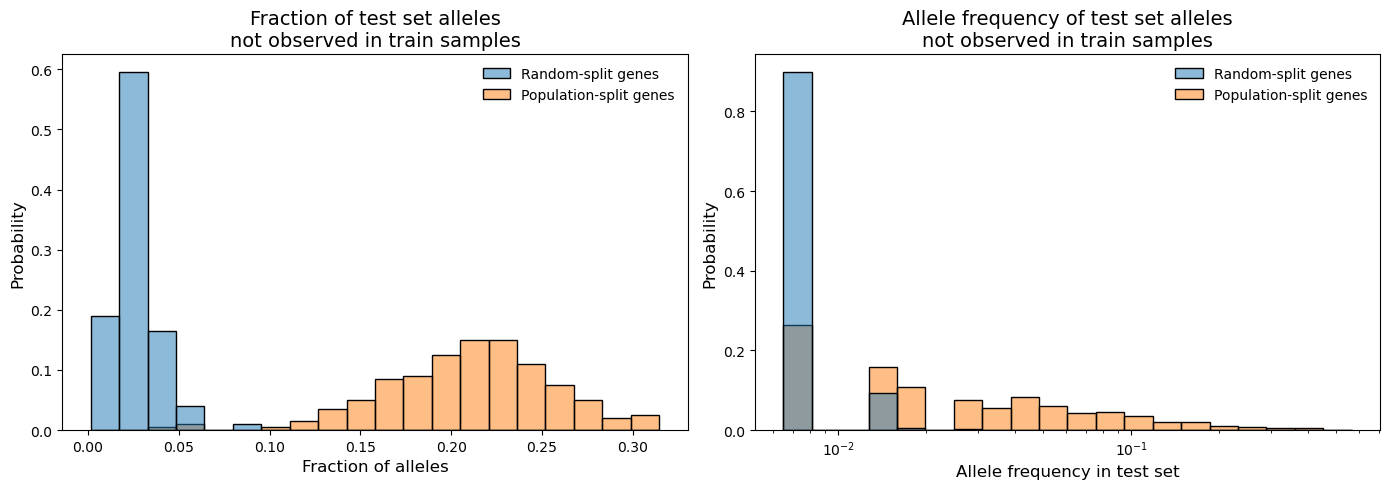

In [26]:
plot_results(
    unseen_alleles_df,
    n_test_alleles_per_gene,
    evaluation_utils.get_gene_to_class_map(),
    os.path.join(FIGURES_DIR, "alleles_unseen_in_train.pdf"),
)

# Correlate fraction of unseen alleles with model performance

In [33]:
PERFORMANCE_BY_GENE_PATH = "../all_gene_perf.csv"
HERITABILITY_PATH = "../../fusion/h2_estimation/heritability.all_samples.tsv"

In [85]:
def average_performance_across_replicates(perf_df: pd.DataFrame, model_names: list[str]):
    perf_df = perf_df[perf_df["model"].isin(model_names)].copy()
    mean_perf_df = perf_df.groupby(["gene"])["Pearson"].mean().reset_index().set_index("gene")
    return mean_perf_df["Pearson"].to_dict()

In [86]:
perf_df = pd.read_csv(PERFORMANCE_BY_GENE_PATH)
perf_df.head()

,gene,Pearson,|Pearson|,model,class,Chr
0,znf83,0.380145,0.380145,classification_data_seed_42_lr_0.0001_wd_0.001...,random_split,19
1,znf83,0.446376,0.446376,classification_data_seed_97_lr_0.0001_wd_0.001...,random_split,19
2,znf83,0.456123,0.456123,classification_data_seed_7_lr_0.0001_wd_0.001_...,random_split,19
3,znf83,0.359325,0.359325,regression_data_seed_42_lr_0.0001_wd_0.001_rcp...,random_split,19
4,znf83,0.438791,0.438791,regression_data_seed_97_lr_0.0001_wd_0.001_rcp...,random_split,19


In [87]:
pattern = r"^regression_data_seed_(\d+)_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3$"
pairwise_regression_models = [m for m in perf_df["model"].unique() if re.match(pattern, m)]
mean_perf_by_gene = average_performance_across_replicates(perf_df, pairwise_regression_models)

In [88]:
def load_heritability_per_gene(heritability_path: str, metric: str = "h") -> dict[str, float]:
    assert metric in ["h", "hsq"], "metric must be either 'h' or 'hsq'"

    heritability_df = pd.read_csv(heritability_path, sep=" ", header=None, names=["hsq", "hsq_se", "pval", "Unknown"])
    heritability_df["gene"] = heritability_df.index.map(lambda x: x.split("/")[-1])
    heritability_df = heritability_df.set_index("gene")
    if metric == "hsq":
        return heritability_df["hsq"].to_dict()
    elif metric == "h":
        heritability_df["h"] = heritability_df["hsq"].apply(lambda x: 0 if x < 0 else x**0.5)
        return heritability_df["h"].to_dict()

In [89]:
heritability_per_gene = load_heritability_per_gene(HERITABILITY_PATH, metric="h")

In [231]:
def plot_fraction_unseen_vs_mean_perf(
    unseen_alleles_df: pd.DataFrame,
    n_test_alleles_per_gene: dict[str, int],
    mean_perf_by_gene: dict[str, float],
    gene_to_class_map: dict[str, str],
    heritability_per_gene: dict[str, float],
    savepath: Optional[str] = None,
):
    unseen_counts = unseen_alleles_df.groupby("gene")["variant"].count()
    results_df = pd.DataFrame(unseen_counts).rename(
        columns={"variant": "n_unseen"}
    )
    results_df["n_test"] = results_df.index.map(n_test_alleles_per_gene)
    results_df["unseen_fraction"] = results_df["n_unseen"] / results_df["n_test"]
    results_df["mean_perf"] = results_df.index.map(mean_perf_by_gene)
    results_df["heritability"] = results_df.index.map(heritability_per_gene)
    results_df["fraction_perf"] = results_df["mean_perf"] / results_df["heritability"]
    results_df["fraction_perf"] = results_df["fraction_perf"].replace([np.inf, -np.inf], np.nan)

    results_df["gene_class"] = results_df.index.map(gene_to_class_map)
    results_df["gene_class"] = results_df["gene_class"].map(
        {"random_split": "Random-split genes", "yri_split": "Population-split genes"}
    )

    fig, axs = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)
    # (A) Random-split genes
    random_split_results_df = results_df[results_df["gene_class"] == "Random-split genes"]
    sns.regplot(
        data=random_split_results_df,
        x="unseen_fraction",
        y="fraction_perf",
        ax=axs[0],
    )
    axs[0].set(xlabel="", ylabel="", title="Random-split genes")
    mask = random_split_results_df["fraction_perf"].notnull()
    r, p = pearsonr(random_split_results_df.loc[mask, "unseen_fraction"], random_split_results_df.loc[mask, "fraction_perf"])
    axs[0].text(
        0.975, 
        0.95, 
        rf"$r$ = {r:.2f}, $p$ = {p:.2f}", 
        transform=axs[0].transAxes, 
        fontsize=10, 
        ha="right",
        c="blue"
    )

    # (B) Population-split genes
    population_split_results_df = results_df[results_df["gene_class"] == "Population-split genes"]
    sns.regplot(
        data=population_split_results_df,
        x="unseen_fraction",
        y="fraction_perf",
        ax=axs[1],
    )
    axs[1].set(xlabel="", ylabel="", title="Population-split genes")
    mask = population_split_results_df["fraction_perf"].notnull()
    r, p = pearsonr(population_split_results_df.loc[mask, "unseen_fraction"], population_split_results_df.loc[mask, "fraction_perf"])
    axs[1].text(
        0.975, 
        0.95, 
        rf"$r={r:.2f}$, $p={p:.2f}$", 
        transform=axs[1].transAxes, 
        fontsize=10, 
        ha="right",
        c="blue"
    )

    fig.supxlabel("Fraction of test set alleles unseen in train samples")
    fig.supylabel(r"$r/h$", ha="center", x=0.05)

    if savepath:
        plt.savefig(savepath, bbox_inches="tight")

    plt.tight_layout()
    plt.show()

    return results_df


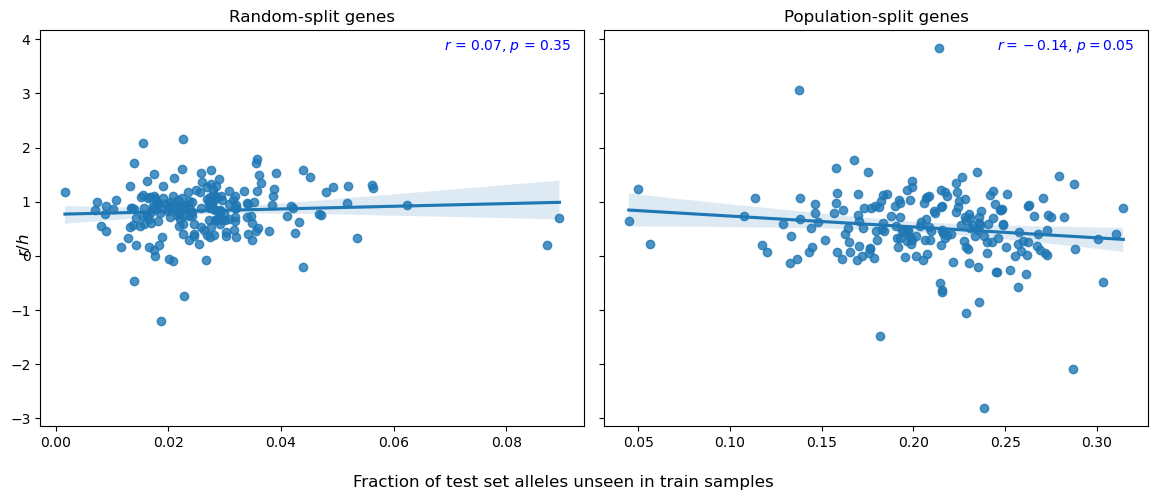

In [232]:
_ = plot_fraction_unseen_vs_mean_perf(
    unseen_alleles_df,
    n_test_alleles_per_gene,
    mean_perf_by_gene,
    evaluation_utils.get_gene_to_class_map(),
    heritability_per_gene,
    os.path.join(FIGURES_DIR, "fraction_unseen_alleles_vs_perf.pdf"),
)

# ISM scores of private Yoruban alleles before and after fine-tuning

In [13]:
BASELINE_ENFORMER_ISM_DIR = "../ISM/baseline.384_bins/"
FINETUNED_ENFORMER_ISM_DIR = "/data/yosef3/scratch/ruchir/finetuning-enformer/saved_models/regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3/ism"

In [14]:
def load_enformer_isms(ism_dir: str, gene: str) -> pd.DataFrame:
    df = pd.read_csv(os.path.join(ism_dir, f"{gene}.csv"), header=0, index_col=0)
    df.index = df.index.map(Variant.create_from_str)
    return df

In [15]:
gene_to_class_map = evaluation_utils.get_gene_to_class_map()
population_split_genes = sorted([g for g, c in gene_to_class_map.items() if c == "yri_split"])

def add_normalized_ISM_metric_to_ism_df(ism_df: pd.DataFrame, gene: str) -> pd.DataFrame:
    max_ism = ism_df["ISM"].abs().max()
    ism_df["norm_ISM"] = ism_df["ISM"].abs() / max_ism
    assert np.isfinite(ism_df["norm_ISM"]).all(), f"norm_ISM for {gene} contains NaN values"
    return ism_df

baseline_private_metrics = []
baseline_nonprivate_metrics = []
finetuned_private_metrics = []
finetuned_nonprivate_metrics = []

for gene in tqdm(population_split_genes):
    baseline_isms = load_enformer_isms(BASELINE_ENFORMER_ISM_DIR, gene)
    finetuned_isms = load_enformer_isms(FINETUNED_ENFORMER_ISM_DIR, gene)
    baseline_isms = add_normalized_ISM_metric_to_ism_df(baseline_isms, gene)
    finetuned_isms = add_normalized_ISM_metric_to_ism_df(finetuned_isms, gene)

    geno_mtx = utils.get_genotype_matrix(
        counts_df.loc[gene, "Chr"],
        counts_df.loc[gene, "Coord"],
        CONTEXT_SIZE,
        remove_ac0=True,
        remove_ac1=True
    )
    train_samples = sorted(train_samples_per_gene[gene])
    test_samples = sorted(test_samples_per_gene[gene])

    train_aaf = compute_alternate_allele_frequency(geno_mtx[train_samples])
    test_aaf = compute_alternate_allele_frequency(geno_mtx[test_samples])
    seen_train_variants = set(train_aaf[train_aaf > 0].index)
    seen_test_variants = set(test_aaf[test_aaf > 0].index)

    private_variants = seen_test_variants - seen_train_variants
    nonprivate_variants = (seen_train_variants | seen_test_variants) - private_variants
    assert (private_variants | nonprivate_variants).issubset(set(baseline_isms.index))
    assert (private_variants | nonprivate_variants).issubset(set(finetuned_isms.index))

    private_variants_l = sorted(private_variants)
    nonprivate_variants_l = sorted(nonprivate_variants)

    baseline_private_metrics.extend(baseline_isms.loc[private_variants_l, "norm_ISM"].values)
    baseline_nonprivate_metrics.extend(baseline_isms.loc[nonprivate_variants_l, "norm_ISM"].values)
    finetuned_private_metrics.extend(finetuned_isms.loc[private_variants_l, "norm_ISM"].values)
    finetuned_nonprivate_metrics.extend(finetuned_isms.loc[nonprivate_variants_l, "norm_ISM"].values)

baseline_private_metrics = np.array(baseline_private_metrics)
baseline_nonprivate_metrics = np.array(baseline_nonprivate_metrics)
finetuned_private_metrics = np.array(finetuned_private_metrics)
finetuned_nonprivate_metrics = np.array(finetuned_nonprivate_metrics)

  0%|          | 0/200 [00:00<?, ?it/s]

In [20]:
results_df = pd.DataFrame({
    "class": 
        ["Baseline Enformer, unseen during training"] * len(baseline_private_metrics) +
        ["Baseline Enformer, seen during training"] * len(baseline_nonprivate_metrics) +
        ["Pairwise regression, unseen during training"] * len(finetuned_private_metrics) +
        ["Pairwise regression, seen during training"] * len(finetuned_nonprivate_metrics),
    "norm_ISM": np.concatenate([
        baseline_private_metrics,
        baseline_nonprivate_metrics,
        finetuned_private_metrics,
        finetuned_nonprivate_metrics
    ])
})
results_df["model"] = results_df["class"].apply(lambda x: x.split(",")[0].strip())
results_df["variant_type"] = results_df["class"].apply(lambda x: x.split(",")[1].strip())

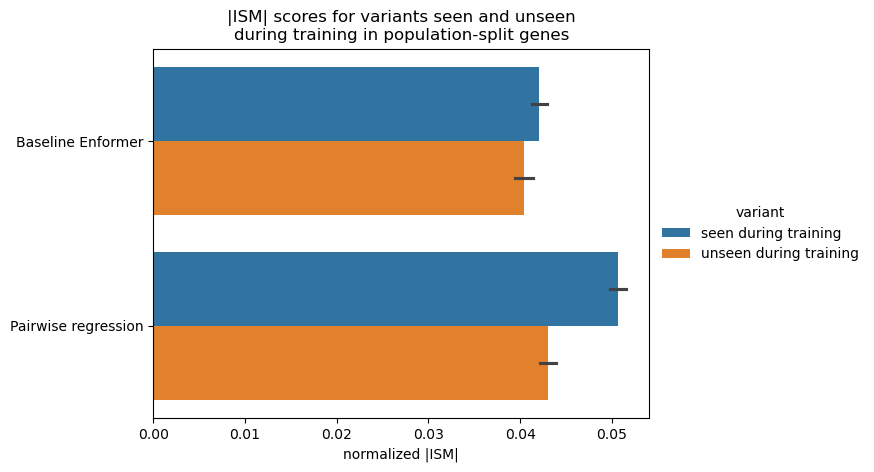

In [23]:
fig, ax = plt.subplots()
sns.barplot(
    data=results_df,
    x="norm_ISM",
    y="model",
    hue="variant_type",
    hue_order=["seen during training", "unseen during training"],
)
ax.set_ylabel("")
ax.set_xlabel("normalized |ISM|")
ax.set_title("|ISM| scores for variants seen and unseen" + "\n" + "during training in population-split genes")
ax.legend(title="variant", loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)

plt.savefig(os.path.join(FIGURES_DIR, "ism_scores_by_seen_population_split.pdf"), bbox_inches="tight")
plt.show()